### Assessing dFC using individual methodologies

In this demo we will illustrate how to use each of the dFC assessment methods implemented in pydfc toolbox.

We use sample data from an openneuro dataset by: Lukas Snoek and Maite van der Miesen and Andries van der Leij and Tinka Beemsterboer and Annemarie Eigenhuis and Steven Scholte (2020). AOMIC-PIOP1. OpenNeuro. [Dataset] doi: 10.18112/openneuro.ds002785.v2.0.0

In [13]:
from pydfc import data_loader
import numpy as np
import warnings

warnings.simplefilter("ignore")

### State-free Methods

These methods do not require any model fitting or brain states estimation. Therefore, they can be simply applied on each single subject's data.

First let's download the fmriprep processed functional data of `sub-0001` from openneuro webiste.

In [6]:
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz?versionId=UfCs4xtwIEPDgmb32qFbtMokl_jxLUKr -o sample_data/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.tsv?versionId=biaIJGNQ22P1l1xEsajVzUW6cnu1_8lD -o sample_data/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  370M    0 1089k    0     0  1334k      0  0:04:44 --:--:--  0:04:44 1335k
  1  370M    1 7328k    0     0  4022k      0  0:01:34  0:00:01  0:01:33 4024k
  8  370M    8 30.2M    0     0  10.7M      0  0:00:34  0:00:02  0:00:32 10.7M
 22  370M   22 82.5M    0     0  21.6M      0  0:00:17  0:00:03  0:00:14 21.6M
 36  370M   36  136M    0     0  28.2M      0  0:00:13  0:00:04  0:00:09 28.2M
 48  370M   48  181M    0     0  31.2M      0  0:00:11  0:00:05  0:00:06 36.1M
 61  370M   61  228M    0     0  33.4M      0  0:00:11  0:00:06  0:00:05 44.2M
 73  370M   73  271M    0     0  34.4M      0  0:00:10  0:00:07  0:00:03 47.5M
 85  370M   85  318M    0     0  36.1M      0  0:00:10  0:00:08  0:00:02 47.1M
100  370M  100  370M    0     0  37.9M      0  0:00

Next we load the downloaded nifti files as a `TIME_SERIES` object and name it `BOLD`.

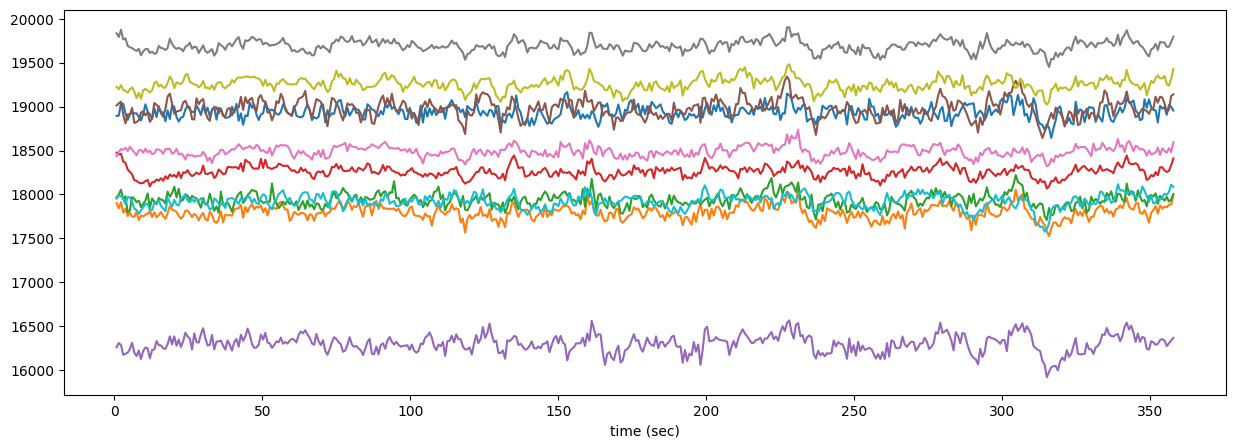

In [2]:
# load sub-0001 data from nifti file
BOLD = data_loader.nifti2timeseries(
    nifti_file="sample_data/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
    n_rois=100,
    Fs=1 / 0.75,
    subj_id="sub-0001",
    confound_strategy="no_motion",  # no_motion, no_motion_no_gsr, or none
    standardize=False,
    TS_name=None,
    session=None,
)

BOLD.visualize(start_time=0, end_time=1000, nodes_lst=range(10))

We could also specify a custom mask to define ROIs from which to extract data:

In [ ]:
# load sub-0001 data from nifti file
BOLD = data_loader.nifti2timeseries(
    nifti_file="sample_data/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
    masker_type="NiftiLabelsMasker",
    labels_img="sample_data/ROI_mask.nii",
    Fs=1 / 0.75,
    subj_id="sub-1092",
    confound_strategy="none",  # no_motion, no_motion_no_gsr, or none
    standardize=False,
    TS_name=None,
    session=None,
)

BOLD.visualize(start_time=0, end_time=1000, nodes_lst=range(30))

TypeError: nifti2timeseries() got an unexpected keyword argument 'labels_img'

#### Sliding Window (SW)

30


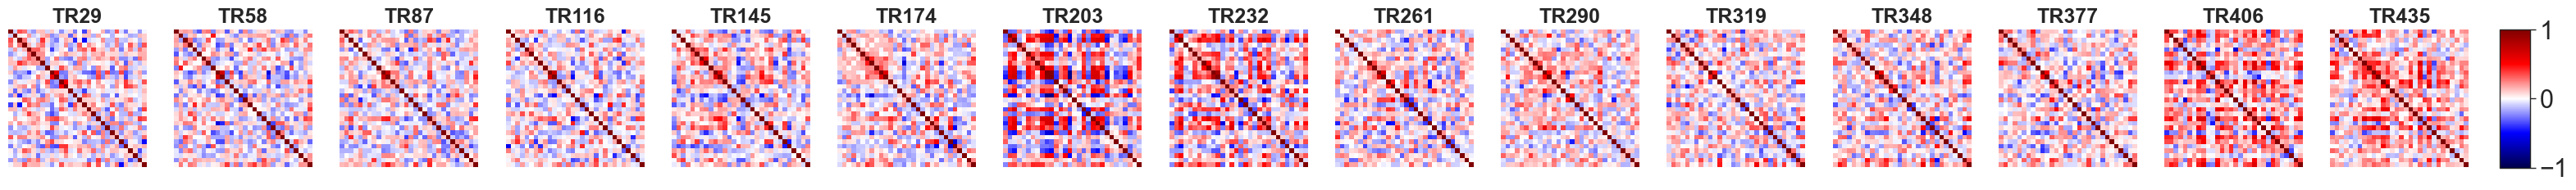

In [9]:
from pydfc.dfc_methods import SLIDING_WINDOW

params_methods = {
    # W is window length in sec
    "W": 44,
    "n_overlap": 0.5,
    "sw_method": "pear_corr",
    "tapered_window": True,
    # data Parameters
    "normalization": True,
    "num_select_nodes": None,  # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = SLIDING_WINDOW(**params_methods)
dFC = measure.estimate_dFC(time_series=BOLD)
print(dFC.n_regions)
dFC.visualize_dFC(
    TRs=dFC.TR_array[:], normalize=False, fix_lim=False
)  # TRs are time point indices, e.g. TR=0 is the first time point, TR=1 is the second time point, etc.

Example: Plotting FC averaged across all connections over time using the obtained dFC

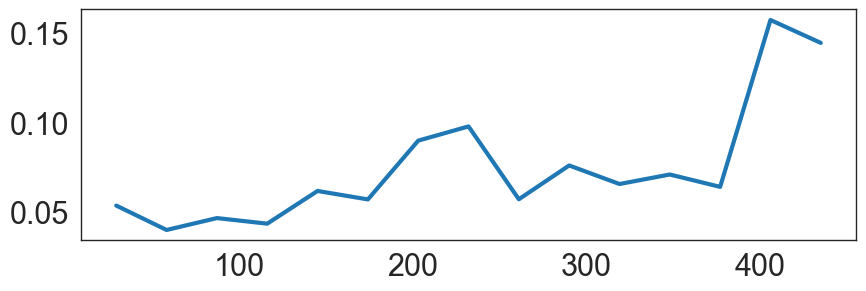

In [10]:
import matplotlib.pyplot as plt

avg_dFC = np.mean(np.mean(dFC.get_dFC_mat(), axis=1), axis=1)
plt.figure(figsize=(10, 3))
plt.plot(dFC.TR_array, avg_dFC)
plt.show()

#### Time-Frequency (TF)

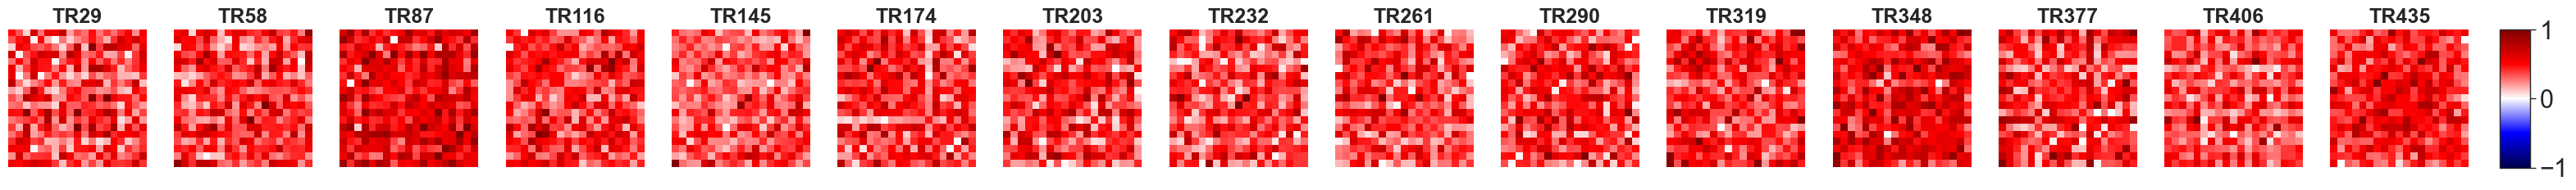

In [5]:
from pydfc.dfc_methods import TIME_FREQ

params_methods = {
    "TF_method": "WTC",
    # Parallelization Parameters
    "n_jobs": 2,
    "verbose": 0,
    "backend": "loky",
    # Data Parameters
    "normalization": True,
    "num_select_nodes": None,  # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = TIME_FREQ(**params_methods)
dFC = measure.estimate_dFC(time_series=BOLD)
TRs = dFC.TR_array[np.arange(29, 480 - 29, 29)]
dFC.visualize_dFC(TRs=TRs, normalize=True, fix_lim=False)

### State-based Methods

The state-based methods require an initial model fitting and functional connectivity states (FCS) estimation on multiple or all subjects.
You can specify the assumed number of brain states by setting "n_states"

First let's download the func data of 5 subjects.

In [7]:
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz?versionId=UfCs4xtwIEPDgmb32qFbtMokl_jxLUKr -o sample_data/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.tsv?versionId=biaIJGNQ22P1l1xEsajVzUW6cnu1_8lD -o sample_data/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.tsv
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0002/func/sub-0002_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz?versionId=fUBWmUTg6vfe2n.ywDNms4mOAW3r6E9Y -o sample_data/sub-0002_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0002/func/sub-0002_task-restingstate_acq-mb3_desc-confounds_regressors.tsv?versionId=2zWQIugU.J6ilTFObWGznJdSABbaTx9F -o sample_data/sub-0002_task-restingstate_acq-mb3_desc-confounds_regressors.tsv
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0003/func/sub-0003_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz?versionId=dfNd8iV0V68yuOibes6qiHxjBgQXhPxi -o sample_data/sub-0003_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0003/func/sub-0003_task-restingstate_acq-mb3_desc-confounds_regressors.tsv?versionId=8OpKFrs_8aJ5cVixokBmuTVKNslgtOXb -o sample_data/sub-0003_task-restingstate_acq-mb3_desc-confounds_regressors.tsv
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0004/func/sub-0004_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz?versionId=0Le8eFwJbcLKaMTQat39bzWcGFhRiyP5 -o sample_data/sub-0004_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0004/func/sub-0004_task-restingstate_acq-mb3_desc-confounds_regressors.tsv?versionId=welg1B.VkXHGv06iV56Vp7ezpVTFh2eX -o sample_data/sub-0004_task-restingstate_acq-mb3_desc-confounds_regressors.tsv
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0005/func/sub-0005_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz?versionId=Vwo2YcFvhwbhZktBrPUqi_5BWiR7zcTl -o sample_data/sub-0005_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0005/func/sub-0005_task-restingstate_acq-mb3_desc-confounds_regressors.tsv?versionId=FoBZLbFTZaE3ZjOLZI_4hN4OkEKEZTVf -o sample_data/sub-0005_task-restingstate_acq-mb3_desc-confounds_regressors.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  370M  100  370M    0     0  1671k      0  0:03:46  0:03:46 --:--:-- 3011k   0     0      0      0 --:--:--  0:00:10 --:--:--     0  0  0:05:33  0:00:39  0:04:54 1417k18  370M   18 67.9M    0     0   950k      0  0:06:39  0:01:13  0:05:26  139k3.6M    0     0  1041k      0  0:06:04  0:01:32  0:04:32 2572k:05:33  0:02:02  0:03:31  846k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2230k  100 2230k    0     0   198k      0  0:00:11  0:00:11 --:--:--  512k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  352M  100  352M    0     0   576k      0  0:10:26  0:10:26 --:--:-- 1353k20.8M    0     0  2499k     

Next we load the downloaded nifti files as `TIME_SERIES` object containing multiple subjects' BOLD signals and name it `BOLD_multi`.

In [8]:
# loading data of multiple subjects from their niifti files
subj_id_list = ["sub-0001", "sub-0002", "sub-0003", "sub-0004", "sub-0005"]
nifti_files_list = []
for subj_id in subj_id_list:
    nifti_files_list.append(
        "sample_data/"
        + subj_id
        + "_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    )

BOLD_multi = data_loader.multi_nifti2timeseries(
    nifti_files_list,
    subj_id_list,
    n_rois=100,
    Fs=1 / 0.75,
    confound_strategy="no_motion",
    standardize=False,
    TS_name=None,
    session=None,
)

#### Co-Activation Patterns (CAP)

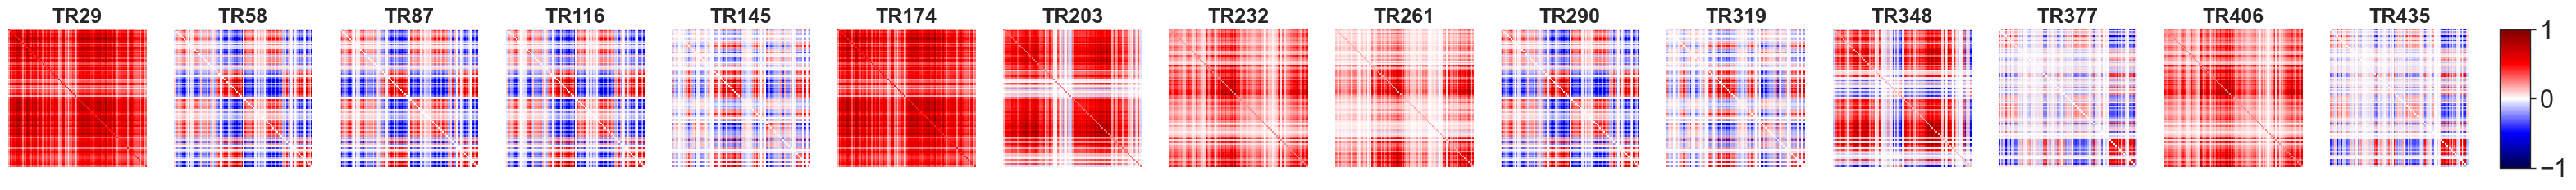

In [9]:
from pydfc.dfc_methods import CAP

params_methods = {
    # State Parameters
    "n_states": 12,
    "n_subj_clstrs": 20,
    # Data Parameters
    "normalization": True,
    "num_subj": None,  # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    "num_select_nodes": None,  # you can make the number of nodes/regions smaller, e.g. by setting to 50, for faster computation
}

measure = CAP(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id="sub-0001"))
TRs = dFC.TR_array[np.arange(29, 480 - 29, 29)]
dFC.visualize_dFC(TRs=TRs, normalize=True, fix_lim=False)

#### Sliding Window + Clustering (SWC)

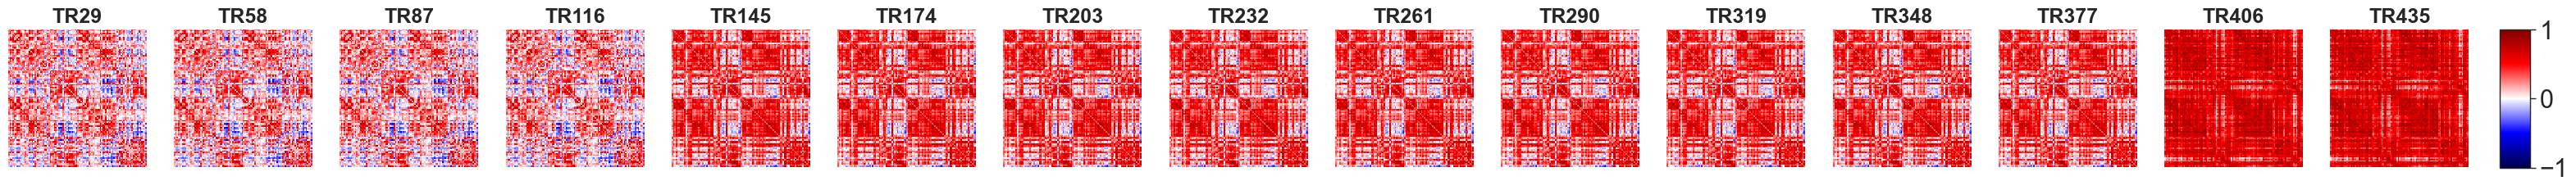

In [10]:
from pydfc.dfc_methods import SLIDING_WINDOW_CLUSTR

params_methods = {
    # Sliding Parameters
    # W is window length in sec
    "W": 44,
    "n_overlap": 0.5,
    "sw_method": "pear_corr",
    "tapered_window": True,
    # CLUSTERING
    "clstr_base_measure": "SlidingWindow",
    # State Parameters
    "n_states": 12,
    "n_subj_clstrs": 5,
    # Data Parameters
    "normalization": True,
    "num_subj": None,  # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    "num_select_nodes": None,  # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = SLIDING_WINDOW_CLUSTR(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id="sub-0001"))
dFC.visualize_dFC(TRs=dFC.TR_array[:], normalize=True, fix_lim=False)

#### Continuous Hidden Markov Model (CHMM)

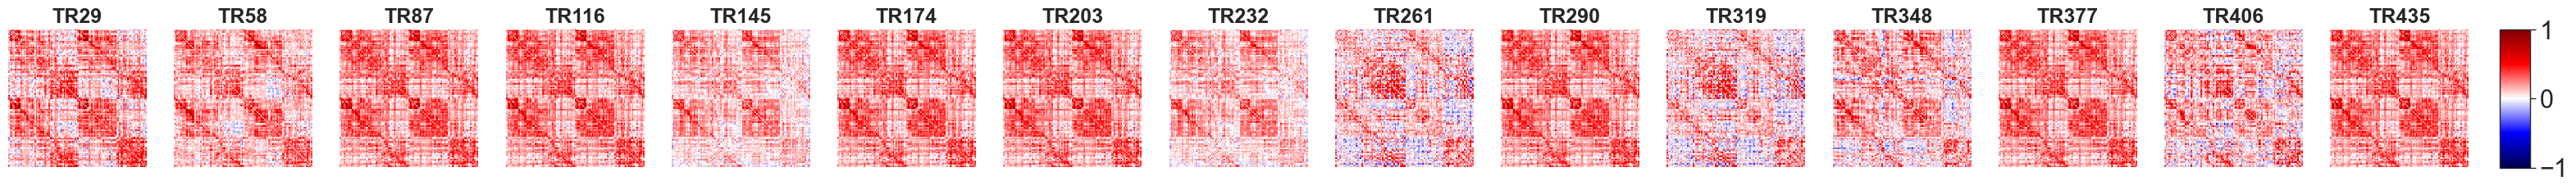

In [11]:
from pydfc.dfc_methods import HMM_CONT

params_methods = {
    # HMM
    "hmm_iter": 20,
    # State Parameters
    "n_states": 12,
    # Data Parameters
    "normalization": True,
    "num_subj": None,  # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    "num_select_nodes": None,  # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = HMM_CONT(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id="sub-0001"))
TRs = dFC.TR_array[np.arange(29, 480 - 29, 29)]
dFC.visualize_dFC(TRs=TRs, normalize=True, fix_lim=False)

#### Discrete Hidden Markov Model (DHMM)

Note that 5 subjects is too small to fit the DHMM model. That is the reason the warning is raised.

Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
F

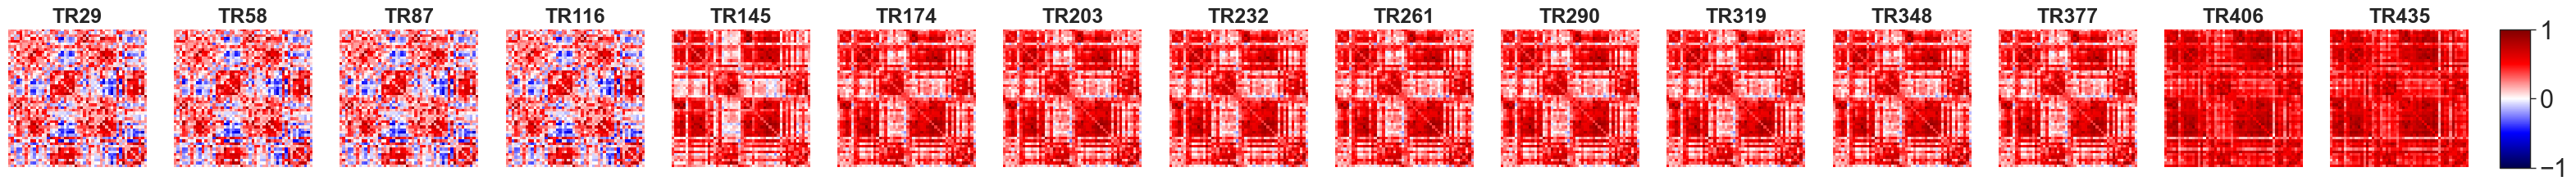

In [12]:
from pydfc.dfc_methods import HMM_DISC

params_methods = {
    # Sliding Parameters
    # W is window length in sec
    "W": 44,
    "n_overlap": 0.5,
    "sw_method": "pear_corr",
    "tapered_window": True,
    # CLUSTERING AND DHMM
    "clstr_base_measure": "SlidingWindow",
    # HMM
    "hmm_iter": 20,
    "dhmm_obs_state_ratio": 16 / 24,
    # State Parameters
    "n_states": 12,
    "n_subj_clstrs": 5,
    # Data Parameters
    "normalization": True,
    "num_subj": None,  # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    "num_select_nodes": 50,  # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = HMM_DISC(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id="sub-0001"))
dFC.visualize_dFC(TRs=dFC.TR_array[:], normalize=True, fix_lim=False)

#### Window-less (WL)

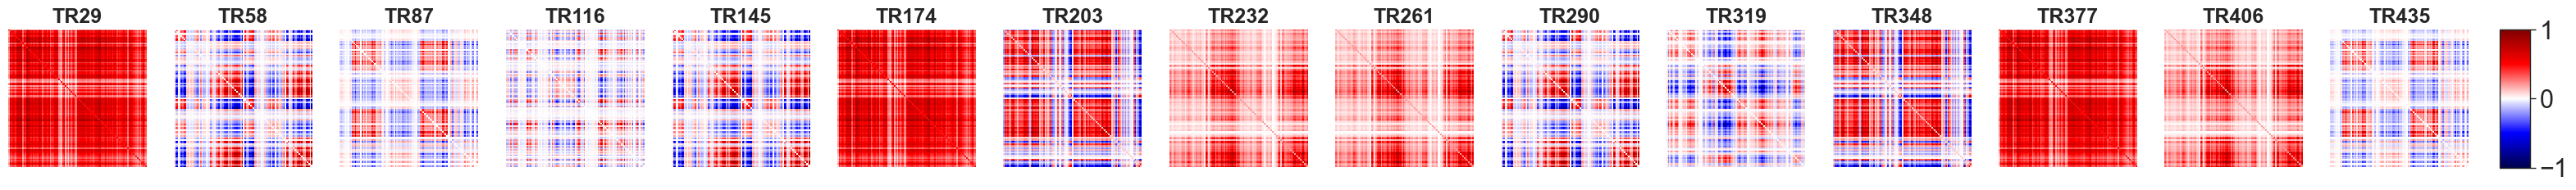

In [13]:
from pydfc.dfc_methods import WINDOWLESS

params_methods = {
    # State Parameters
    "n_states": 12,
    # Data Parameters
    "normalization": True,
    "num_subj": None,  # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    "num_select_nodes": None,  # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = WINDOWLESS(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id="sub-0001"))
TRs = dFC.TR_array[np.arange(29, 480 - 29, 29)]
dFC.visualize_dFC(TRs=TRs, normalize=True, fix_lim=False)